# Scratch analysis

Compare the RDMs of ANN models trained with interleaved training of all 64 task sets (each batch contains all 64 task sets), versus sequential training of 4 practiced task sets and then 60 novel task sets

9/3/2020

In [1]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import runANNs_CL as run
from model import model_cl as model
from model import analysis
from model import task
from importlib import reload
import tools
import pandas as pd

In [2]:
nsimulations = 20

# Train sequential practiced &rarr; novel tasks

#### load trials and create 'test sets'

In [9]:
run = reload(run)
model = reload(model)
task = reload(task)

#### batchfilename
datadir = '../../data/'
# batchfilename = datadir + 'results/model/TrialBatches_4Prac60Nov_FullStimSets'
batchfilename = datadir + 'results/model/Experiment_FullTaskSet'
experiment = task.Experiment(NUM_INPUT_ELEMENTS=28,
                             NUM_OUTPUT_ELEMENTS=4,
                             filename=batchfilename)


# print("creating practiced batches")
# experiment.createFullTaskSet(condition='practice')
# print("creating novel batches")
# experiment.createFullTaskSet(condition='novel')
# print("creating all batches")
# experiment.createFullTaskSet(condition='all')

print("loading practiced set")
# #### Construct training set for 'practiced' and 'full' task set
prac_inputs, prac_targets = experiment.loadFullTask(condition='practice')
prac_inputs = prac_inputs.reshape(prac_inputs.shape[0]*prac_inputs.shape[1],prac_inputs.shape[2])
prac_targets = prac_targets.reshape(prac_targets.shape[0]*prac_targets.shape[1],prac_targets.shape[2])
full_inputs, full_targets = experiment.loadFullTask(condition='all')

experiment.practice_input_batches = prac_inputs
experiment.practice_output_batches = prac_targets

experiment.online_input_batches = full_inputs
experiment.online_output_batches = full_targets

Loading previously constructed practiced and novel rule sets...
loading practiced set


In [4]:
#########################################
#### Construct test set
ntrials_per_task = 100
#### Construct test set for 'practiced' trials based on task similarity
test_prac_inputs, test_prac_targets = task.create_random_trials(experiment.practicedRuleSet,ntrials_per_task,np.random.randint(1000000))
test_prac_inputs = torch.from_numpy(test_prac_inputs.T).float()
test_prac_targets = torch.from_numpy(test_prac_targets.T).float()

#### Now identify overlap with practiced tasks in the novel task set
taskSim1Set, taskSim2Set = experiment.taskSimilarity(experiment.practicedRuleSet,experiment.novelRuleSet)

# Make even the number of trials for each task set
# ntrials1 = int((ntrials*len(trialobj.practicedRuleSet))/len(taskSim1Set))
# ntrials2 = int((ntrials*len(trialobj.practicedRuleSet))/len(taskSim2Set))
# ntrials1 = ntrials
# ntrials2 = ntrials

#### Simulate task sets with 2-rule similarities
sim2_inputs, sim2_targets = task.create_random_trials(taskSim2Set,ntrials_per_task,np.random.randint(1000000))
sim2_inputs = torch.from_numpy(sim2_inputs.T).float()
sim2_targets = torch.from_numpy(sim2_targets.T).float()

#### Simulate task sets with 1-rule similarities
sim1_inputs, sim1_targets = task.create_random_trials(taskSim1Set,ntrials_per_task,np.random.randint(1000000))
sim1_inputs = torch.from_numpy(sim1_inputs.T).float()
sim1_targets = torch.from_numpy(sim1_targets.T).float()


## Train only practiced tasks

In [5]:
model = reload(model)
run = reload(run)

nsimulations = 20
si_c = 1.0
acc_cutoff = 90.0
thresh = 0.0
learning_rate = 0.01
num_hidden = 512
df = {}
df['Accuracy'] = []
df['Condition'] = []
df['Simulation'] = []
#### Run simulation
online_accuracies = []
for i in range(nsimulations):
    print('Training simulation', i)
    network_prac2nov, ntrials_viewed, acc = run.runModel(experiment,si_c=si_c,acc_cutoff=acc_cutoff,learning='online',datadir='../../data/',practice=True,
                                                    num_hidden=num_hidden,thresh=thresh,learning_rate=learning_rate,
                                                    save_model='ANN_OnlineLearning.pt',verbose=False)
    network_prac2nov.eval()
    online_accuracies.append(acc)
        
    # practice trials
    outputs, hidden = network_prac2nov.forward(test_prac_inputs[:,:],noise=True)
    acc = np.mean(model.accuracyScore(network_prac2nov,outputs,test_prac_targets[:,:]))
    df['Accuracy'].append(acc)
    df['Condition'].append('Practiced')
    df['Simulation'].append(i)
    print('\t Practiced acc =',acc)
    
    # 2-rule overlap
    outputs, hidden = network_prac2nov.forward(sim2_inputs,noise=True)
    acc = np.mean(model.accuracyScore(network_prac2nov,outputs,sim2_targets))
    df['Accuracy'].append(acc)
    df['Condition'].append('2-rule overlap')
    df['Simulation'].append(i)
    print('\t 2-rule overlap acc =',acc)    

    # 1-rule overlap
    outputs, hidden = network_prac2nov.forward(sim1_inputs,noise=True)
    acc = np.mean(model.accuracyScore(network_prac2nov,outputs,sim1_targets))
    df['Accuracy'].append(acc)
    df['Condition'].append('1-rule overlap')
    df['Simulation'].append(i)
    print('\t 1-rule overlap acc =',acc)   

Training simulation 0
	 Practiced acc = 0.85
	 2-rule overlap acc = 0.7636111111111111
	 1-rule overlap acc = 0.7541666666666667
Training simulation 1
	 Practiced acc = 0.86
	 2-rule overlap acc = 0.8080555555555555
	 1-rule overlap acc = 0.80625
Training simulation 2
	 Practiced acc = 0.73
	 2-rule overlap acc = 0.7502777777777778
	 1-rule overlap acc = 0.7391666666666666
Training simulation 3
	 Practiced acc = 0.895
	 2-rule overlap acc = 0.7958333333333333
	 1-rule overlap acc = 0.78375
Training simulation 4
	 Practiced acc = 0.8375
	 2-rule overlap acc = 0.77
	 1-rule overlap acc = 0.7508333333333334
Training simulation 5
	 Practiced acc = 0.8925
	 2-rule overlap acc = 0.8275
	 1-rule overlap acc = 0.83375
Training simulation 6
	 Practiced acc = 0.8075
	 2-rule overlap acc = 0.7822222222222223
	 1-rule overlap acc = 0.7779166666666667
Training simulation 7
	 Practiced acc = 0.78
	 2-rule overlap acc = 0.7669444444444444
	 1-rule overlap acc = 0.7579166666666667
Training simulation 

## Practiced training only - Plot behavioral accuracy for practiced, 2-rule overlap, and 1-rule overlap tasks separately

Practice accuracy: 0.8125
2-rule overlap accuracy: 0.7757916666666667
1-rule overlap accuracy: 0.7670625000000001
Practiced versus 2-rule: stat = 21.0 | p = 0.000850677490234375
2-rule versus 1-rule: stat = 20.0 | p = 0.0007076263427734375


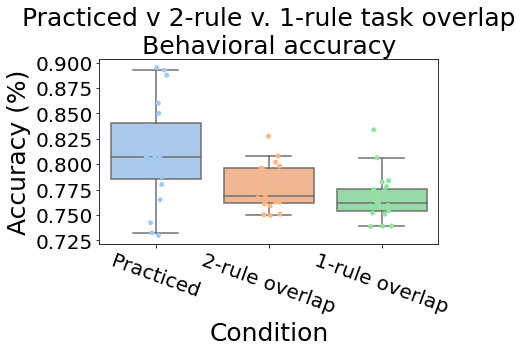

In [6]:
df = pd.DataFrame(df)
prac_acc = df.loc[df['Condition']=='Practiced']
rule2_acc = df.loc[df['Condition']=='2-rule overlap']
rule1_acc = df.loc[df['Condition']=='1-rule overlap']
print('Practice accuracy:', np.mean(prac_acc.Accuracy.values))
print('2-rule overlap accuracy:', np.mean(rule2_acc.Accuracy.values))
print('1-rule overlap accuracy:', np.mean(rule1_acc.Accuracy.values))
t, p = stats.wilcoxon(prac_acc.Accuracy.values,rule2_acc.Accuracy.values)
print('Practiced versus 2-rule: stat =', t, '| p =', p)
t, p = stats.wilcoxon(rule2_acc.Accuracy.values,rule1_acc.Accuracy.values)
print('2-rule versus 1-rule: stat =', t, '| p =', p)


plt.figure(figsize=(7,5))
plt.title('Practiced v 2-rule v. 1-rule task overlap\nBehavioral accuracy',fontsize=25)
ax = sns.boxplot(x="Condition",y="Accuracy",data=df,
           medianprops={'linestyle':'-'},sym='',whis=[2.5,97.5],palette="pastel")
ax = sns.stripplot(x="Condition",y="Accuracy",data=df,
              dodge=True,palette="pastel")
plt.xticks(rotation=-20,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Accuracy (%)',fontsize=25)
plt.xlabel('Condition', fontsize=25)
plt.tight_layout()

Practice accuracy: 0.8280859375
2-rule overlap accuracy: 0.7841276041666666
1-rule overlap accuracy: 0.7875227864583333
Practiced versus 2-rule: stat = 4.0 | p = 9.634403725281619e-10
2-rule versus 1-rule: stat = 359.0 | p = 0.007178040847589355


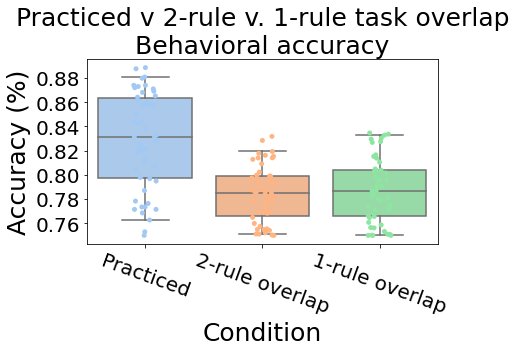

In [46]:
df = pd.read_csv('ANN_OnlineLearning.csv')
prac_acc = df.loc[df['Condition']=='Practiced']
rule2_acc = df.loc[df['Condition']=='2-rule overlap']
rule1_acc = df.loc[df['Condition']=='1-rule overlap']
print('Practice accuracy:', np.mean(prac_acc.Accuracy.values))
print('2-rule overlap accuracy:', np.mean(rule2_acc.Accuracy.values))
print('1-rule overlap accuracy:', np.mean(rule1_acc.Accuracy.values))
t, p = stats.wilcoxon(prac_acc.Accuracy.values,rule2_acc.Accuracy.values)
print('Practiced versus 2-rule: stat =', t, '| p =', p)
t, p = stats.wilcoxon(rule2_acc.Accuracy.values,rule1_acc.Accuracy.values)
print('2-rule versus 1-rule: stat =', t, '| p =', p)


plt.figure(figsize=(7,5))
plt.title('Practiced v 2-rule v. 1-rule task overlap\nBehavioral accuracy',fontsize=25)
ax = sns.boxplot(x="Condition",y="Accuracy",data=df,
           medianprops={'linestyle':'-'},sym='',whis=[2.5,97.5],palette="pastel")
ax = sns.stripplot(x="Condition",y="Accuracy",data=df,
              dodge=True,palette="pastel")
plt.xticks(rotation=-20,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Accuracy (%)',fontsize=25)
plt.xlabel('Condition', fontsize=25)
plt.tight_layout()

Practice accuracy: 0.796240234375
2-rule overlap accuracy: 0.7998480902777778
1-rule overlap accuracy: 0.7995768229166668
Practiced versus 2-rule: stat = 87.0 | p = 0.5216732025146484
2-rule versus 1-rule: stat = 88.0 | p = 0.5458755493164062


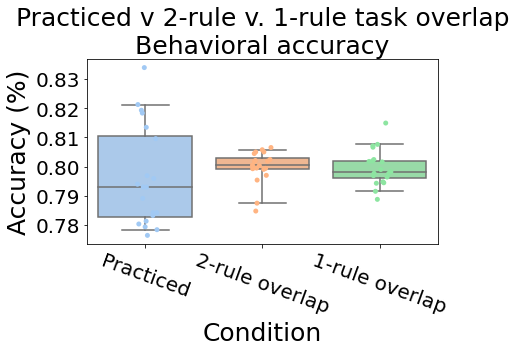

In [60]:
df = pd.read_csv('ANN_OnlineLearning.csv')
prac_acc = df.loc[df['Condition']=='Practiced']
rule2_acc = df.loc[df['Condition']=='2-rule overlap']
rule1_acc = df.loc[df['Condition']=='1-rule overlap']
print('Practice accuracy:', np.mean(prac_acc.Accuracy.values))
print('2-rule overlap accuracy:', np.mean(rule2_acc.Accuracy.values))
print('1-rule overlap accuracy:', np.mean(rule1_acc.Accuracy.values))
t, p = stats.wilcoxon(prac_acc.Accuracy.values,rule2_acc.Accuracy.values)
print('Practiced versus 2-rule: stat =', t, '| p =', p)
t, p = stats.wilcoxon(rule2_acc.Accuracy.values,rule1_acc.Accuracy.values)
print('2-rule versus 1-rule: stat =', t, '| p =', p)


plt.figure(figsize=(7,5))
plt.title('Practiced v 2-rule v. 1-rule task overlap\nBehavioral accuracy',fontsize=25)
ax = sns.boxplot(x="Condition",y="Accuracy",data=df,
           medianprops={'linestyle':'-'},sym='',whis=[2.5,97.5],palette="pastel")
ax = sns.stripplot(x="Condition",y="Accuracy",data=df,
              dodge=True,palette="pastel")
plt.xticks(rotation=-20,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Accuracy (%)',fontsize=25)
plt.xlabel('Condition', fontsize=25)
plt.tight_layout()

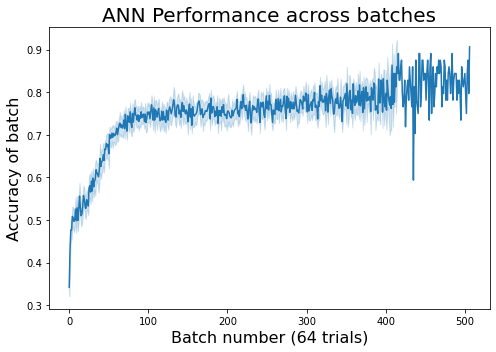

In [7]:
df_online_acc = {}
df_online_acc['Simulation'] = []
df_online_acc['Batch'] = []
df_online_acc['Accuracy'] = []

count = 1
for sim in online_accuracies:
    nbatches = len(sim)
    df_online_acc['Batch'].extend(np.arange(nbatches))
    df_online_acc['Simulation'].extend(np.repeat(count,nbatches))
    df_online_acc['Accuracy'].extend(sim)
    count += 1
    
df_online_acc = pd.DataFrame(df_online_acc)
plt.figure(figsize=(7,5))
sns.lineplot(x="Batch",y="Accuracy",data=df_online_acc)
plt.title('ANN Performance across batches',fontsize=20)
plt.xlabel('Batch number (64 trials)', fontsize=16)
plt.ylabel('Accuracy of batch', fontsize=16)
plt.tight_layout()

___

## Train practiced tasks (in batches), followed by online learning for all tasks

In [ ]:
model = reload(model)
run = reload(run)

nsimulations = 20
acc_cutoff = 80.0
thresh = 0.8
learning_rate = 0.001
num_hidden = 32
df = {}
df['Accuracy'] = []
df['Condition'] = []
df['Simulation'] = []
#### Run simulation
online_accuracies = []
for i in range(nsimulations):
    print('Training simulation', i)
    network_prac2nov, ntrials_viewed, acc = run.runModel(experiment,acc_cutoff=acc_cutoff,learning=None,datadir='../../data/',practice=True,
                                                    num_hidden=num_hidden,thresh=thresh,learning_rate=learning_rate,
                                                    save_model='ANN_OnlineLearning.pt',verbose=False)
    online_accuracies.append(acc)
    
#     network_prac2nov.thresh = 0.8
    
    # practice trials
    outputs, hidden = network_prac2nov.forward(test_prac_inputs[:,:],noise=True)
    acc = np.mean(model.accuracyScore(network_prac2nov,outputs,test_prac_targets[:,:]))
    df['Accuracy'].append(acc)
    df['Condition'].append('Practiced')
    df['Simulation'].append(i)
    print('\t Practiced acc =',acc)
    
    # 2-rule overlap
    outputs, hidden = network_prac2nov.forward(sim2_inputs,noise=True)
    acc = np.mean(model.accuracyScore(network_prac2nov,outputs,sim2_targets))
    df['Accuracy'].append(acc)
    df['Condition'].append('2-rule overlap')
    df['Simulation'].append(i)
    print('\t 2-rule overlap acc =',acc)    

    # 1-rule overlap
    outputs, hidden = network_prac2nov.forward(sim1_inputs,noise=True)
    acc = np.mean(model.accuracyScore(network_prac2nov,outputs,sim1_targets))
    df['Accuracy'].append(acc)
    df['Condition'].append('1-rule overlap')
    df['Simulation'].append(i)
    print('\t 1-rule overlap acc =',acc)   

## Plot behavioral accuracy for practiced, 2-rule overlap, and 1-rule overlap tasks separately

In [ ]:
df = pd.DataFrame(df)
prac_acc = df.loc[df['Condition']=='Practiced']
rule2_acc = df.loc[df['Condition']=='2-rule overlap']
rule1_acc = df.loc[df['Condition']=='1-rule overlap']
print('Practice accuracy:', np.mean(prac_acc.Accuracy.values))
print('2-rule overlap accuracy:', np.mean(rule2_acc.Accuracy.values))
print('1-rule overlap accuracy:', np.mean(rule1_acc.Accuracy.values))
t, p = stats.wilcoxon(prac_acc.Accuracy.values,rule2_acc.Accuracy.values)
print('Practiced versus 2-rule: stat =', t, '| p =', p)
t, p = stats.wilcoxon(rule2_acc.Accuracy.values,rule1_acc.Accuracy.values)
print('2-rule versus 1-rule: stat =', t, '| p =', p)


plt.figure(figsize=(7,5))
plt.title('Practiced v 2-rule v. 1-rule task overlap\nBehavioral accuracy',fontsize=25)
ax = sns.boxplot(x="Condition",y="Accuracy",data=df,
           medianprops={'linestyle':'-'},sym='',whis=[2.5,97.5],palette="pastel")
ax = sns.stripplot(x="Condition",y="Accuracy",data=df,
              dodge=True,palette="pastel")
plt.xticks(rotation=-20,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Accuracy (%)',fontsize=25)
plt.xlabel('Condition', fontsize=25)
plt.tight_layout()

In [ ]:
df_online_acc = {}
df_online_acc['Simulation'] = []
df_online_acc['Batch'] = []
df_online_acc['Accuracy'] = []

count = 1
for sim in online_accuracies:
    nbatches = len(sim)
    df_online_acc['Batch'].extend(np.arange(nbatches))
    df_online_acc['Simulation'].extend(np.repeat(count,nbatches))
    df_online_acc['Accuracy'].extend(sim)
    count += 1
    
df_online_acc = pd.DataFrame(df_online_acc)
plt.figure(figsize=(7,5))
sns.lineplot(x="Batch",y="Accuracy",data=df_online_acc)
plt.title('ANN Performance across batches',fontsize=20)
plt.xlabel('Batch number (64 trials)', fontsize=16)
plt.ylabel('Accuracy of batch', fontsize=16)
plt.tight_layout()

# Train tasks non-sequentially

In [ ]:
run = reload(run)
dim_cov_interlve = []
dim_corr_interlve = []
nbatches_interlve = []
nsamples_interlve = []
for i in range(nsimulations):
    network_interlve, trialobj, tmp1, tmp2 = run.runModel(datadir='../../data/',practice=False,create_new_batches=False,
                                                save_model='ANN_AllTaskTraining.pt',verbose=False)
    nsamples_interlve.append(tmp1)
    nbatches_interlve.append(tmp2)
    hidden_interlve_corr, rsm_interlve_corr = analysis.rsa_pracnov(network_interlve,measure='corr')
    hidden_interlve_cov, rsm_interlve_cov = analysis.rsa_pracnov(network_interlve,measure='cov')
    dim_corr_interlve.append(tools.dimensionality(rsm_interlve_corr))
    dim_cov_interlve.append(tools.dimensionality(rsm_interlve_cov))

# Visualize RSM for last simulation (correlation-based)

In [ ]:
plt.figure(figsize=(14,14))
plt.subplot(121)
plt.title('Sequential training RSM',fontsize=28)
ax = sns.heatmap(rsm_prac2nov_corr,square=True,center=0,vmin=-0.3,vmax=0.9,cmap='bwr', cbar=True,cbar_kws={'fraction':0.046})
plt.xlabel('64 task contexts',fontsize=20)
plt.ylabel('64 task contexts',fontsize=20)
# plt.xticks(np.arange(0.5, rsm_prac2nov.shape[0]+1), rotation=90,fontsize=14)
# plt.yticks(np.arange(0.5, rsm_prac2nov.shape[0]+1), rotation=0, fontsize=14)
plt.tight_layout()
ax.invert_yaxis()

plt.subplot(122)
plt.title('Interleaved training RSM',fontsize=28)
ax = sns.heatmap(rsm_interlve_corr,square=True,center=0,vmin=-0.3,vmax=0.9,cmap='bwr', cbar=True,cbar_kws={'fraction':0.046})
plt.xlabel('64 task contexts',fontsize=20)
plt.ylabel('64 task contexts',fontsize=20)
# plt.xticks(np.arange(0.5, rsm_prac2nov.shape[0]+1), rotation=90,fontsize=14)
# plt.yticks(np.arange(0.5, rsm_prac2nov.shape[0]+1), rotation=0, fontsize=14)
plt.tight_layout()
ax.invert_yaxis()

# Visualize RSM for last simulation (covariance-based)

In [ ]:
analysis = reload(analysis)

plt.figure(figsize=(14,14))
plt.subplot(121)
plt.title('Sequential training RSM',fontsize=28)
ax = sns.heatmap(rsm_prac2nov_cov,square=True,center=0,cmap='bwr',vmin=-0.05,vmax=0.2,cbar=True,cbar_kws={'fraction':0.046})
plt.xlabel('64 task contexts',fontsize=20)
plt.ylabel('64 task contexts',fontsize=20)
# plt.xticks(np.arange(0.5, rsm_prac2nov.shape[0]+1), rotation=90,fontsize=14)
# plt.yticks(np.arange(0.5, rsm_prac2nov.shape[0]+1), rotation=0, fontsize=14)
plt.tight_layout()
ax.invert_yaxis()

plt.subplot(122)
plt.title('Interleaved training RSM',fontsize=28)
ax = sns.heatmap(rsm_interlve_cov,square=True,center=0,cmap='bwr',vmin=-0.05,vmax=0.2,cbar=True,cbar_kws={'fraction':0.046})
plt.xlabel('64 task contexts',fontsize=20)
plt.ylabel('64 task contexts',fontsize=20)
# plt.xticks(np.arange(0.5, rsm_prac2nov.shape[0]+1), rotation=90,fontsize=14)
# plt.yticks(np.arange(0.5, rsm_prac2nov.shape[0]+1), rotation=0, fontsize=14)
plt.tight_layout()
ax.invert_yaxis()



# Compute dimensionality of sequential versus interleaved training RDMs using participation ratio (eigendecomposition of RDM)
Participation ratio, as computed by Abbott et al. 2011

In [ ]:
dim_df = {}
dim_df['Type'] = []
dim_df['Dimensionality'] = []
dim_df['Measure'] = []
for i in range(nsimulations):

    dim_df['Type'].append('Interleaved')
    dim_df['Dimensionality'].append(dim_corr_interlve[i])
    dim_df['Measure'].append('Correlation')
    #
    dim_df['Type'].append('Sequential')
    dim_df['Dimensionality'].append(dim_corr_prac2nov[i])
    dim_df['Measure'].append('Correlation')
    #
    #
    dim_df['Type'].append('Interleaved')
    dim_df['Dimensionality'].append(dim_cov_interlve[i])
    dim_df['Measure'].append('Covariance')
    #
    dim_df['Type'].append('Sequential')
    dim_df['Dimensionality'].append(dim_cov_prac2nov[i])
    dim_df['Measure'].append('Covariance')

dim_df = pd.DataFrame(dim_df)
sns.boxplot(x="Measure", y="Dimensionality", hue='Type', data=dim_df)
plt.title("Dimensionality of RSMs",fontsize=18)
plt.xlabel('Training regimen',fontsize=16)
plt.ylabel('Dimensionality',fontsize=16)
